In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [2]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d
    
def MSE(v):
    return np.sqrt(np.sum((func(v)-sig)**2))

In [8]:
stime = "indep" # "dep", "indep"
sfreq = "indep" # "dep", "indep"

smix = "NoTransformation" # "NoTransformation", "CompleteExchange", "AdiabaticMSW"
shier = "normal" # "normal", "inverted"
smodel = "Tamborra_2014_20M" # "Tamborra_2014_11M", "Tamborra_2014_20M", "Tamborra_2014_27M"
sdir = 1

filename1 = './files/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2.pkl'
filename2 = './files/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.pkl'


file1 = open(filename1, 'rb')
data1 = pickle.load(file1)
file2 = open(filename2, 'rb')
data2 = pickle.load(file2)

distances1, Sts1_gen2, Sts1_ic86, Bts1_gen2, Bts1_ic86, Z1_gen2, Z1_ic86 = data1
distances2, Sts2_gen2, Sts2_ic86, Bts2_gen2, Bts2_ic86, Z2_gen2, Z2_ic86 = data2

In [9]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)

dmax = np.max((distances1,distances2))*u.kpc
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

In [11]:
#interpolations of the significance data
d = 6 * u.kpc
sig_wls_50 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[0])
sig_gen2_50 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[0])
sig_ic86_50 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[0])

sig_wls_14 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[1])
sig_gen2_14 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[1])
sig_ic86_14 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[1])

sig_wls_86 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[2])
sig_gen2_86 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[2])
sig_ic86_86 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[2])

sd_ccsn = PchipInterpolator(sd.dist.value, sd.cdf)

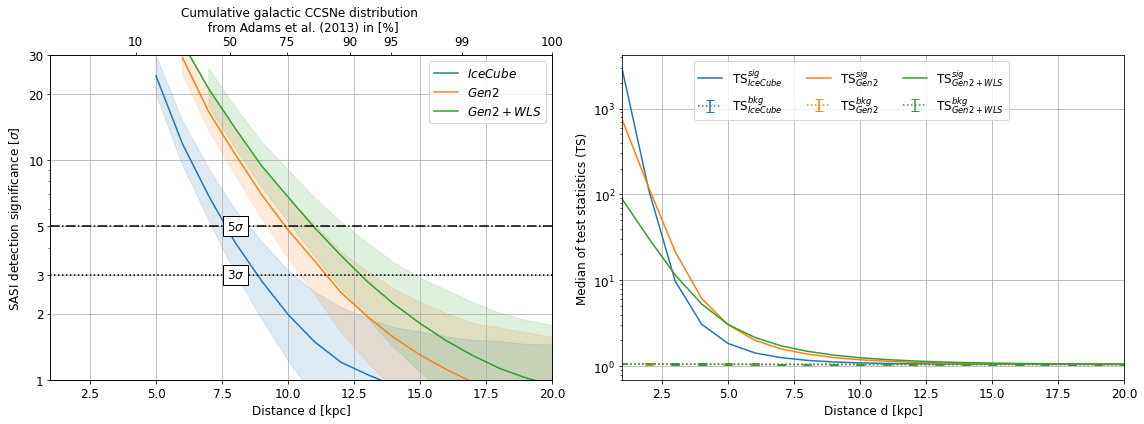

In [14]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.ravel()

ax[0].plot(distances1, Z1_ic86.T[0], color = 'C0', label=r'$IceCube$')
ax[0].plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'$Gen2$')
ax[0].plot(distances1, Z2_gen2.T[0], color = 'C2', label=r'$Gen2+WLS$')

ax[0].fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax[0].fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax[0].fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax[0].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[0].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 12)
ax[0].set_xlim((1,20))
ax[0].set_ylim((1,30))

ax[0].tick_params(labelsize = 12)

ax[0].set_yscale('log')
ax[0].set_yticks([1,2,3,5,10,20,30])
ax[0].set_yticklabels(['1','2','3','5','10','20','30'])

ax[0].grid()
ax[0].legend(loc='upper right', fontsize = 12)

ax[0].axhline(3, color='k', ls = ':')
ax[0].axhline(5, color='k', ls = '-.')
ax[0].text(8, 3, r"3$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[0].text(8, 5, r"5$\sigma$", size=12,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[0].twiny()
ax22.set_xlim(ax[0].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 12)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 12)

#signal without errorbar
ax[1].plot(distances1, Sts1_ic86.T[0], color = 'C0', label=r'TS$^{sig}_{IceCube}$')
ax[1].plot(distances1, Sts1_gen2.T[0], color = 'C1', label=r'TS$^{sig}_{Gen2}$')
ax[1].plot(distances2, Sts2_gen2.T[0], color = 'C2', label=r'TS$^{sig}_{Gen2+WLS}$')

#background with errorbar
ax[1].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
ax[1].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax[1].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')

#rearrange legend handels
handles,labels = ax[1].get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]


ax[1].set_xlabel('Distance d [kpc]', fontsize = 12)
ax[1].set_ylabel('Median of test statistics (TS)', fontsize = 12)
ax[1].set_xlim((1,20))
ax[1].set_yscale('log')
ax[1].tick_params(labelsize = 12)
ax[1].legend(handles, labels, ncol = 3, fontsize = 12, bbox_to_anchor=(0.13, 1))
ax[1].grid()

plt.tight_layout()

filename = './plots/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.png'
plt.savefig(filename, dpi = 200, facecolor = 'white')

In [90]:
#write results into txt file

filename = './logs/freq_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.txt' 
with open(filename, 'a') as f:
    for sig in [3,5]:
        print("{} sigma detection level".format(sig), file=f)
        for det in ["wls", "gen2", "ic86"]:
            print(det, file=f)
            if det == "wls":
                funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
            elif det == "gen2":
                funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
            elif det == "ic86":
                funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]

            dist, perc = [], []
            for func in funcs:
                xini = 5
                loss = 1
                while loss > 1E-3:
                    res = minimize(MSE, x0=xini)
                    loss = res.fun
                    xini += 1
                    if xini > 20:
                        print('Minimization did not converge')
                        break
                dist.append(res.x)
                if res.x >= 25:
                    perc.append(np.array([1]))
                else:
                    perc.append(sd_ccsn(res.x))
            dist = np.concatenate(dist)
            perc = np.concatenate(perc)*100
            print("Distance: ({:.1f}+{:.1f}-{:.1f}) kpc".format(dist[1], dist[2]-dist[1], dist[1]-dist[0]), file=f)
            print("Coverage: ({:.1f}+{:.1f}-{:.1f}) % \n".format(perc[1], perc[2]-perc[1], perc[1]-perc[0]), file=f)

In [91]:
#prints values for LaTeX label

for det in ["ic86", "gen2", "wls"]:
    dist, perc = [], []
    for sig in [3,5]:
        if det == "wls":
            funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
        elif det == "gen2":
            funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
        elif det == "ic86":
            funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
        for func in funcs:
            xini = 8
            loss = 1
            while loss > 1E-3:
                res = minimize(MSE, x0=xini)
                loss = res.fun
                xini += 1
                if xini > 20:
                    print('Minimization did not converge')
                    break
            dist.append(res.x)
            if res.x >= 25:
                perc.append(np.array([1]))
            else:
                perc.append(sd_ccsn(res.x))
    dist = np.concatenate(dist)
    perc = np.concatenate(perc)*100
    
    string = '\makecell{{${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)\\\[2mm]${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$ (${:.1f}^{{+{:.1f}}}_{{{:.1f}}}$)}}'.format(dist[1], dist[2]-dist[1], dist[0]-dist[1], perc[1], perc[2]-perc[1], perc[0]-perc[1], dist[4], dist[5]-dist[4], dist[3]-dist[4], perc[4], perc[5]-perc[4], perc[3]-perc[4])
    
    if det != "wls":
        addon = ' & '
    else:
        addon = ' \\\*[8mm]'
    print(string + addon)

\makecell{$9.4^{+1.6}_{-1.0}$ ($48.5^{+16.8}_{-11.9}$)\\m]$8.1^{+1.1}_{-0.8}$ ($32.9^{+12.4}_{-7.6}$)} & 
\makecell{$12.0^{+2.1}_{-1.2}$ ($72.6^{+12.3}_{-10.4}$)\\m]$10.3^{+1.3}_{-1.0}$ ($58.1^{+11.9}_{-10.3}$)} & 
\makecell{$13.5^{+2.2}_{-1.5}$ ($82.0^{+9.1}_{-9.5}$)\\m]$11.5^{+1.6}_{-1.2}$ ($68.5^{+11.3}_{-11.1}$)} \\*m]


In [93]:
#prints values for summary plot below

for det in ["ic86", "gen2", "wls"]:
    dist, perc = [], []
    for sig in [3,5]:
        if det == "wls":
            funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
        elif det == "gen2":
            funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
        elif det == "ic86":
            funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]
        for func in funcs:
            xini = 8
            loss = 1
            while loss > 1E-3:
                res = minimize(MSE, x0=xini)
                loss = res.fun
                xini += 1
                if xini > 20:
                    print('Minimization did not converge')
                    break
            dist.append(res.x)
            if res.x >= 25:
                perc.append(np.array([1]))
            else:
                perc.append(sd_ccsn(res.x))
    dist = np.concatenate(dist)
    perc = np.concatenate(perc)*100
    
    string = det + " = np.array([[{:.1f},{:.1f},{:.1f}],[{:.1f},{:.1f},{:.1f}]])".format(dist[1], dist[1]-dist[0], dist[2]-dist[1], dist[4], dist[4]-dist[3], dist[5]-dist[4])
    print(string)

ic86 = np.array([[9.4,1.0,1.6],[8.1,0.8,1.1]])
gen2 = np.array([[12.0,1.2,2.1],[10.3,1.0,1.3]])
wls = np.array([[13.5,1.5,2.2],[11.5,1.2,1.6]])


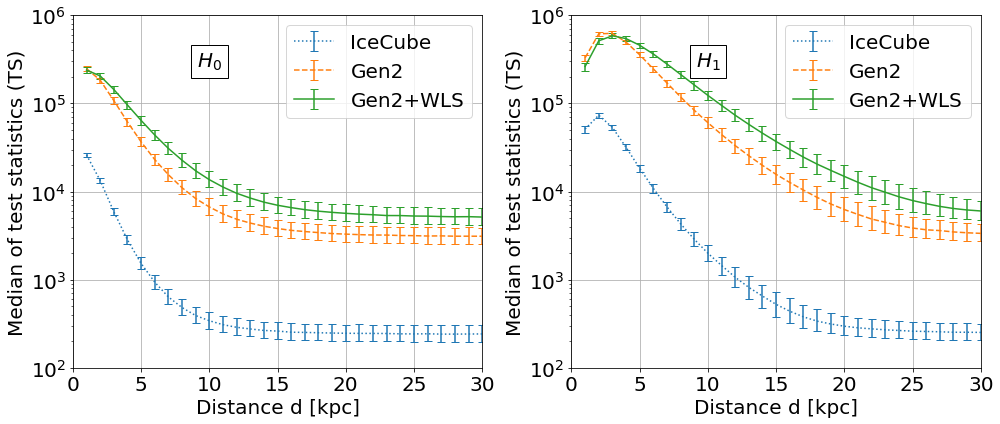

In [11]:
'''
fig, ax = plt.subplots(1,2, figsize = (14,6))

#background with errorbar
ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[0].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[0].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[0].text(10, 3E5, r"$H_0$", size=20,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


#signal without errorbar

ax[1].errorbar(x=distances1, y=Sts1_ic86.T[0],yerr=(Sts1_ic86.T[0]-Sts1_ic86.T[1],Sts1_ic86.T[2]-Sts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label='IceCube')
ax[1].errorbar(x=distances1, y=Sts1_gen2.T[0],yerr=(Sts1_gen2.T[0]-Sts1_gen2.T[1],Sts1_gen2.T[2]-Sts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = '--', label='Gen2')
ax[1].errorbar(x=distances2, y=Sts2_gen2.T[0],yerr=(Sts2_gen2.T[0]-Sts2_gen2.T[1],Sts2_gen2.T[2]-Sts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = '-', label='Gen2+WLS')
ax[1].text(10, 3E5, r"$H_1$", size=20,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)

for i in range(2):
    ax[i].set_xlabel('Distance d [kpc]', fontsize = 20)
    ax[i].set_ylabel('Median of test statistics (TS)', fontsize = 20)
    ax[i].set_xlim((0,30))
    ax[i].set_ylim((1E2,1E6))
    ax[i].set_yscale('log')
    ax[i].tick_params(labelsize = 20)
    ax[i].legend(fontsize = 20)
    ax[i].grid()
plt.tight_layout()
plt.savefig('../plots/ftf_bj_tsdistance.pdf', dpi = 200, facecolor = 'white')
'''

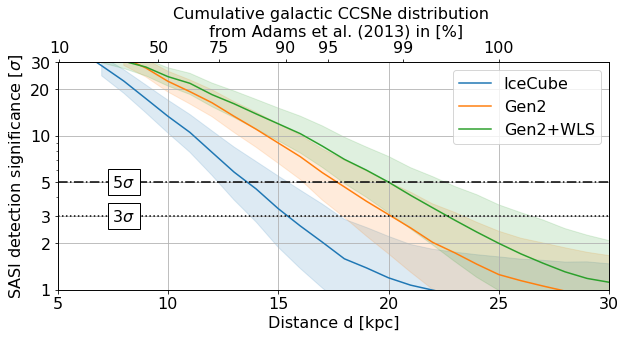

In [12]:
"""
fig, ax = plt.subplots(1,1, figsize = (10,6))
font = {'size'   : 50}

mpl.rc('font', **font)

ax.plot(distances1, Z1_ic86.T[0], color = 'C0', label=r'IceCube')
ax.plot(distances1, Z1_gen2.T[0], color = 'C1', label=r'Gen2')
ax.plot(distances1, Z2_gen2.T[0], color = 'C2', label=r'Gen2+WLS')

ax.fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax.fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax.fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax.set_xlabel('Distance d [kpc]', fontsize = 16)
ax.set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = 16)
ax.set_xlim((5,30))
ax.set_ylim((1,30))

ax.tick_params(labelsize = 16)

ax.set_yscale('log')
ax.set_yticks([1,2,3,5,10,20,30])
ax.set_yticklabels(['1','2','3','5','10','20','30'])

ax.grid()
ax.legend(loc='upper right', fontsize = 16)

ax.axhline(3, color='k', ls = ':')
ax.axhline(5, color='k', ls = '-.')
ax.text(8, 3, r"3$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax.text(8, 5, r"5$\sigma$", size=16,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax.twiny()
ax22.set_xlim(ax.get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_bj_results.pdf', dpi = 200, facecolor = 'white')
"""

In [94]:
vanilla_ic86 = np.array([[15.4,1.7,2.3],[13.6,1.5,1.8]])
vanilla_gen2 = np.array([[20.1,2.2,3.3],[17.7,1.5,2.3]])
vanilla_wls = np.array([[22.7,2.5,3.8],[20.0,2.1,2.6]])

freqdep_ic86 = np.array([[17.2,2.5,4.3],[14.1,2.1,2.3]])
freqdep_gen2 = np.array([[22.5,3.3,5.2],[18.3,2.1,3.0]])
freqdep_wls = np.array([[25.4,3.8,6.2],[20.5,2.4,3.5]])

timedep_ic86 = np.array([[17.5,1.9,2.9],[15.7,1.5,2.0]])
timedep_gen2 = np.array([[23.0,2.5,3.6],[20.6,1.8,2.7]])
timedep_wls = np.array([[26.1,2.9,4.4],[23.3,2.3,3.0]])

freqtimedep_ic86 = np.array([[21.4,3.4,6.3],[18.5,2.3,3.5]])
freqtimedep_gen2 = np.array([[28.2,4.5,8.3],[24.3,3.1,4.7]])
freqtimedep_wls = np.array([[32.1,5.0,9.2],[27.6,3.4,5.1]])

compex_ic86 = np.array([[10.1,1.3,1.9],[8.6,1.1,1.4]])
compex_gen2 = np.array([[13.0,1.8,2.3],[11.0,1.3,1.9]])
compex_wls = np.array([[14.4,2.0,2.8],[12.3,1.7,2.1]])

mswnh_ic86 = np.array([[14.0,1.6,2.4],[12.3,1.2,1.7]])
mswnh_gen2 = np.array([[18.2,2.0,3.0],[15.9,1.5,2.2]])
mswnh_wls = np.array([[20.5,2.4,3.3],[17.8,1.8,2.5]])

mswih_ic86 = np.array([[10.2,1.3,1.9],[8.7,1.1,1.5]])
mswih_gen2 = np.array([[13.1,1.7,2.3],[11.3,1.3,1.7]])
mswih_wls = np.array([[14.6,1.9,2.7],[12.5,1.7,2.0]])

m27d1_ic86 = np.array([[10.8,1.1,1.7],[9.2,0.7,1.2]])
m27d1_gen2 = np.array([[13.7,1.3,2.1],[11.8,1.0,1.3]])
m27d1_wls = np.array([[15.4,1.6,2.5],[13.1,1.3,1.7]])

m27d2_ic86 = np.array([[9.9,1.1,1.6],[8.4,0.8,1.2]])
m27d2_gen2 = np.array([[12.5,1.4,2.1],[10.7,1.0,1.4]])
m27d2_wls = np.array([[14.0,1.5,2.3],[11.9,1.3,1.6]])

m27d3_ic86 = np.array([[9.4,1.0,1.6],[8.1,0.8,1.1]])
m27d3_gen2 = np.array([[12.0,1.2,2.1],[10.3,1.0,1.3]])
m27d3_wls = np.array([[13.5,1.5,2.2],[11.5,1.2,1.6]])

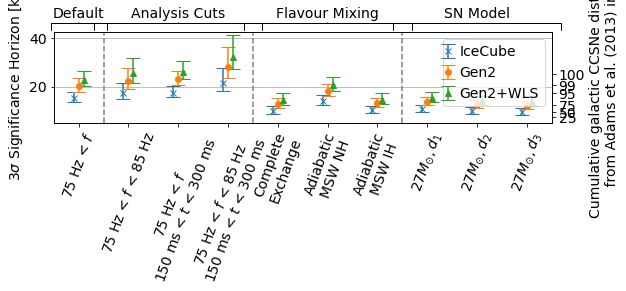

In [95]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(1,1, figsize = (10,6))
xlabels = [r'75 Hz < $f$', r'75 Hz < $f$ < 85 Hz', '75 Hz < $f$\n150 ms < $t$ < 300 ms', '75 Hz < $f$ < 85 Hz\n150 ms < $t$ < 300 ms', 
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')


ax.errorbar(x=0.9, y=freqdep_ic86[0][0], yerr=freqdep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=freqdep_gen2[0][0], yerr=freqdep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=freqdep_wls[0][0], yerr=freqdep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=timedep_ic86[0][0], yerr=timedep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=timedep_gen2[0][0], yerr=timedep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=timedep_wls[0][0], yerr=timedep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqtimedep_ic86[0][0], yerr=freqtimedep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqtimedep_gen2[0][0], yerr=freqtimedep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqtimedep_wls[0][0], yerr=freqtimedep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(3.5, color = 'grey', ls = '--')

ax.errorbar(x=3.9, y=compex_ic86[0][0], yerr=compex_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=compex_gen2[0][0], yerr=compex_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=compex_wls[0][0], yerr=compex_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=mswnh_ic86[0][0], yerr=mswnh_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=mswnh_gen2[0][0], yerr=mswnh_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=mswnh_wls[0][0], yerr=mswnh_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=5.9, y=mswih_ic86[0][0], yerr=mswih_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=mswih_gen2[0][0], yerr=mswih_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=mswih_wls[0][0], yerr=mswih_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(6.5, color = 'grey', ls = '--')

ax.errorbar(x=6.9, y=m27d1_ic86[0][0], yerr=m27d1_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=m27d1_gen2[0][0], yerr=m27d1_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=m27d1_wls[0][0], yerr=m27d1_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=m27d2_ic86[0][0], yerr=m27d2_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=m27d2_gen2[0][0], yerr=m27d2_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=m27d2_wls[0][0], yerr=m27d2_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=8.9, y=m27d3_ic86[0][0], yerr=m27d3_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d3_gen2[0][0], yerr=m27d3_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d3_wls[0][0], yerr=m27d3_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = 14)
ax.grid(axis='y')
ax.set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 14)
ax.set_xlim(-0.5,9.5)
ax.set_ylim(5,42.5)
ax.set_ylabel(r'$3\sigma$ Significance Horizon [kpc]', fontsize=14)
ax.legend(loc = 'upper right', fontsize=14)

rates = np.array([0.25,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 14)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 14)

ax.annotate('Default', xy=(0.05, 1.1), xytext=(0.05, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.25, 1.1), xytext=(0.25, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.55, 1.1), xytext=(0.55, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.85, 1.1), xytext=(0.85, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

plt.tight_layout()
plt.savefig('../plots/ftf_bj_all_3sigma.pdf', dpi = 200)

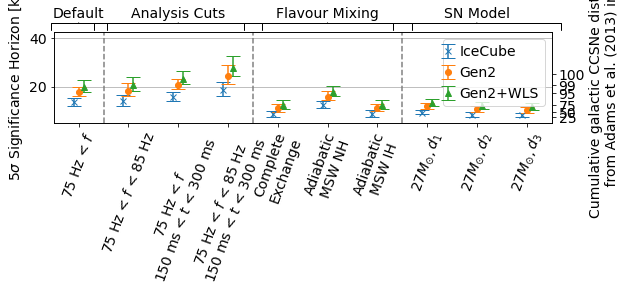

In [96]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(1,1, figsize = (10,6))
xlabels = [r'75 Hz < $f$', r'75 Hz < $f$ < 85 Hz', '75 Hz < $f$\n150 ms < $t$ < 300 ms', '75 Hz < $f$ < 85 Hz\n150 ms < $t$ < 300 ms', 
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')


ax.errorbar(x=0.9, y=freqdep_ic86[1][0], yerr=freqdep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=freqdep_gen2[1][0], yerr=freqdep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=freqdep_wls[1][0], yerr=freqdep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=timedep_ic86[1][0], yerr=timedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=timedep_gen2[1][0], yerr=timedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=timedep_wls[1][0], yerr=timedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqtimedep_ic86[1][0], yerr=freqtimedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqtimedep_gen2[1][0], yerr=freqtimedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqtimedep_wls[1][0], yerr=freqtimedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(3.5, color = 'grey', ls = '--')

ax.errorbar(x=3.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=5.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(6.5, color = 'grey', ls = '--')

ax.errorbar(x=6.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=8.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = 14)
ax.grid(axis='y')
ax.set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 14)
ax.set_xlim(-0.5,9.5)
ax.set_ylim(5,42.5)

ax.set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=14)
ax.legend(loc = 'upper right', fontsize=14)

rates = np.array([0.25,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 14)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = 14)


ax.annotate('Default', xy=(0.05, 1.1), xytext=(0.05, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.25, 1.1), xytext=(0.25, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.55, 1.1), xytext=(0.55, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.85, 1.1), xytext=(0.85, 1.2), xycoords='axes fraction', 
            fontsize=14, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.5', lw=1.0, color='k'))


plt.tight_layout()
plt.savefig('../plots/ftf_bj_all_5sigma.pdf', dpi = 200)

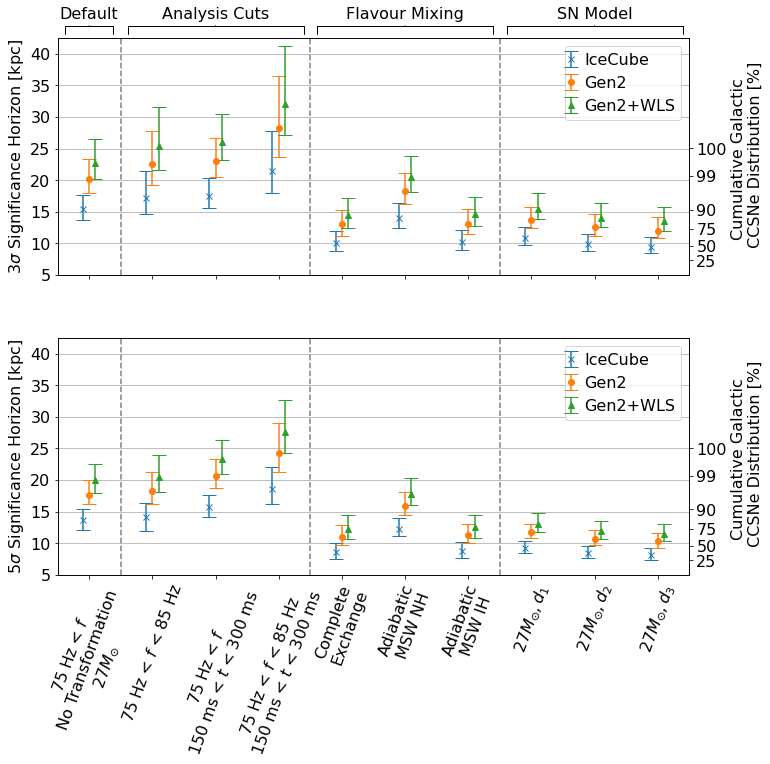

In [102]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fig, ax = plt.subplots(2,1, figsize = (12,12), sharex = True)
xlabels = ['75 Hz < $f$\nNo Transformation\n$27 M_{\odot}$', r'75 Hz < $f$ < 85 Hz', '75 Hz < $f$\n150 ms < $t$ < 300 ms', '75 Hz < $f$ < 85 Hz\n150 ms < $t$ < 300 ms', 
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax[0].errorbar(x=-0.1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=0, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=0.1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(0.5, color = 'grey', ls = '--')


ax[0].errorbar(x=0.9, y=freqdep_ic86[0][0], yerr=freqdep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=1, y=freqdep_gen2[0][0], yerr=freqdep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=1.1, y=freqdep_wls[0][0], yerr=freqdep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=1.9, y=timedep_ic86[0][0], yerr=timedep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=2, y=timedep_gen2[0][0], yerr=timedep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=2.1, y=timedep_wls[0][0], yerr=timedep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=2.9, y=freqtimedep_ic86[0][0], yerr=freqtimedep_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=3, y=freqtimedep_gen2[0][0], yerr=freqtimedep_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=3.1, y=freqtimedep_wls[0][0], yerr=freqtimedep_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(3.5, color = 'grey', ls = '--')

ax[0].errorbar(x=3.9, y=compex_ic86[0][0], yerr=compex_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=4, y=compex_gen2[0][0], yerr=compex_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=4.1, y=compex_wls[0][0], yerr=compex_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=4.9, y=mswnh_ic86[0][0], yerr=mswnh_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=5, y=mswnh_gen2[0][0], yerr=mswnh_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=5.1, y=mswnh_wls[0][0], yerr=mswnh_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=5.9, y=mswih_ic86[0][0], yerr=mswih_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=6, y=mswih_gen2[0][0], yerr=mswih_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=6.1, y=mswih_wls[0][0], yerr=mswih_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].axvline(6.5, color = 'grey', ls = '--')

ax[0].errorbar(x=6.9, y=m27d1_ic86[0][0], yerr=m27d1_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=7, y=m27d1_gen2[0][0], yerr=m27d1_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=7.1, y=m27d1_wls[0][0], yerr=m27d1_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=7.9, y=m27d2_ic86[0][0], yerr=m27d2_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=8, y=m27d2_gen2[0][0], yerr=m27d2_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=8.1, y=m27d2_wls[0][0], yerr=m27d2_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=8.9, y=m27d3_ic86[0][0], yerr=m27d3_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[0].errorbar(x=9, y=m27d3_gen2[0][0], yerr=m27d3_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[0].errorbar(x=9.1, y=m27d3_wls[0][0], yerr=m27d3_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[0].errorbar(x=-1, y=vanilla_ic86[0][0], yerr=vanilla_ic86[0][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax[0].errorbar(x=-1, y=vanilla_gen2[0][0], yerr=vanilla_gen2[0][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax[0].errorbar(x=-1, y=vanilla_wls[0][0], yerr=vanilla_wls[0][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax[0].tick_params(labelsize = 16)
ax[0].grid(axis='y')
ax[0].set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 16, visible = False)
ax[0].set_yticks([5,10,15,20,25,30,35,40])
ax[0].set_xlim(-0.5,9.5)
ax[0].set_ylim(5,42.5)
ax[0].set_ylabel(r'$3\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[0].legend(loc = 'upper right', fontsize=16)

rates = np.array([0.25,0.5,0.75,0.9,0.99,1])
ax21 = ax[0].twinx()
ax21.set_ylim(ax[0].get_ylim())
ax21.set_yticks(inv_cdf(rates).flatten())
ax21.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax21.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

ax[0].annotate('Default', xy=(0.05, 1.05), xytext=(0.05, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Analysis Cuts', xy=(0.25, 1.05), xytext=(0.25, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('Flavour Mixing', xy=(0.55, 1.05), xytext=(0.55, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=0.5', lw=1.0, color='k'))

ax[0].annotate('SN Model', xy=(0.85, 1.05), xytext=(0.85, 1.1), xycoords='axes fraction', 
            fontsize=16, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=0.5', lw=1.0, color='k'))


ax[1].errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(0.5, color = 'grey', ls = '--')


ax[1].errorbar(x=0.9, y=freqdep_ic86[1][0], yerr=freqdep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=1, y=freqdep_gen2[1][0], yerr=freqdep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=1.1, y=freqdep_wls[1][0], yerr=freqdep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=1.9, y=timedep_ic86[1][0], yerr=timedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=2, y=timedep_gen2[1][0], yerr=timedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=2.1, y=timedep_wls[1][0], yerr=timedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=2.9, y=freqtimedep_ic86[1][0], yerr=freqtimedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=3, y=freqtimedep_gen2[1][0], yerr=freqtimedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=3.1, y=freqtimedep_wls[1][0], yerr=freqtimedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(3.5, color = 'grey', ls = '--')

ax[1].errorbar(x=3.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=4, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=4.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=4.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=5, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=5.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=5.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=6, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=6.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].axvline(6.5, color = 'grey', ls = '--')

ax[1].errorbar(x=6.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=7, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=7.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=7.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=8, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=8.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=8.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax[1].errorbar(x=9, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax[1].errorbar(x=9.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax[1].errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax[1].errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax[1].errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')

ax[1].tick_params(labelsize = 16)
ax[1].grid(axis='y')
ax[1].set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = 16)
ax[1].set_yticks([5,10,15,20,25,30,35,40])
ax[1].set_xlim(-0.5,9.5)
ax[1].set_ylim(5,42.5)

ax[1].set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=16)
ax[1].legend(loc = 'upper right', fontsize=16)

rates = np.array([0.25,0.5,0.75,0.9,0.99,1])
ax22 = ax[1].twinx()
ax22.set_ylim(ax[1].get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = 16)
ax22.set_ylabel('Cumulative Galactic \n CCSNe Distribution [%]', fontsize = 16)

plt.tight_layout()
plt.savefig('../plots/ftf_bj_all_3+5sigma.pdf', dpi = 200)

In [ ]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,4))

pdf, bins = np.histogram(sd.distance(100000).value, range = (0,25), bins = 50, density = True)
x = (bins[1:]+bins[:-1])/2

cdf = np.cumsum(pdf)
cdf /= cdf[-1]

ax.step(x, pdf, c = 'C0')
ax.set_xlabel('Distance [kpc]', fontsize = 16)
ax.yaxis.label.set_color('C0')
ax.tick_params(axis='y', colors='C0', labelsize = 16)
ax.set_ylabel('PDF', fontsize = 16)
ax.tick_params(axis='x', labelsize = 16)
ax.set_xlim((0,25))
ax.set_ylim((0,0.12))

ax2 = ax.twinx()
ax2.step(x, cdf, c = 'C1')
ax2.yaxis.label.set_color('C1')
ax2.tick_params(axis='y', colors='C1', labelsize = 16)
ax2.set_ylabel('CDF', fontsize = 16)
ax2.set_ylim((0,1.05))

plt.tight_layout()
plt.savefig('../plots/ftf_steldist.pdf', dpi = 300)